# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
# importamos las librerias necesarias
import os 
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('./Dataset/Proyecto-SIS330.v12i.coco-segmentation') # Path del dataset
images_train = [path/'train'/i for i in os.listdir(path/'train')] # path de las imagenes de entrenamiento
mascaras_train = [path/'trainmasks'/i for i in os.listdir(path/'trainmasks')] # path de las mascaras de entrenamiento
images_test = [path/'valid'/i for i in os.listdir(path/'valid')] # path de las imagenes de test
mascaras_test = [path/'validmasks'/i for i in os.listdir(path/'validmasks')] # path de las mascaras de test

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [2]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.
        
        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)
        
        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)
    
    return np.array(imagenes), np.array(mascaras)

In [3]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (502, 480, 864, 3)
Forma de las máscaras numpy: (502, 480, 864, 3)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [27]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [28]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((480, 864, 3), (480, 864, 3))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

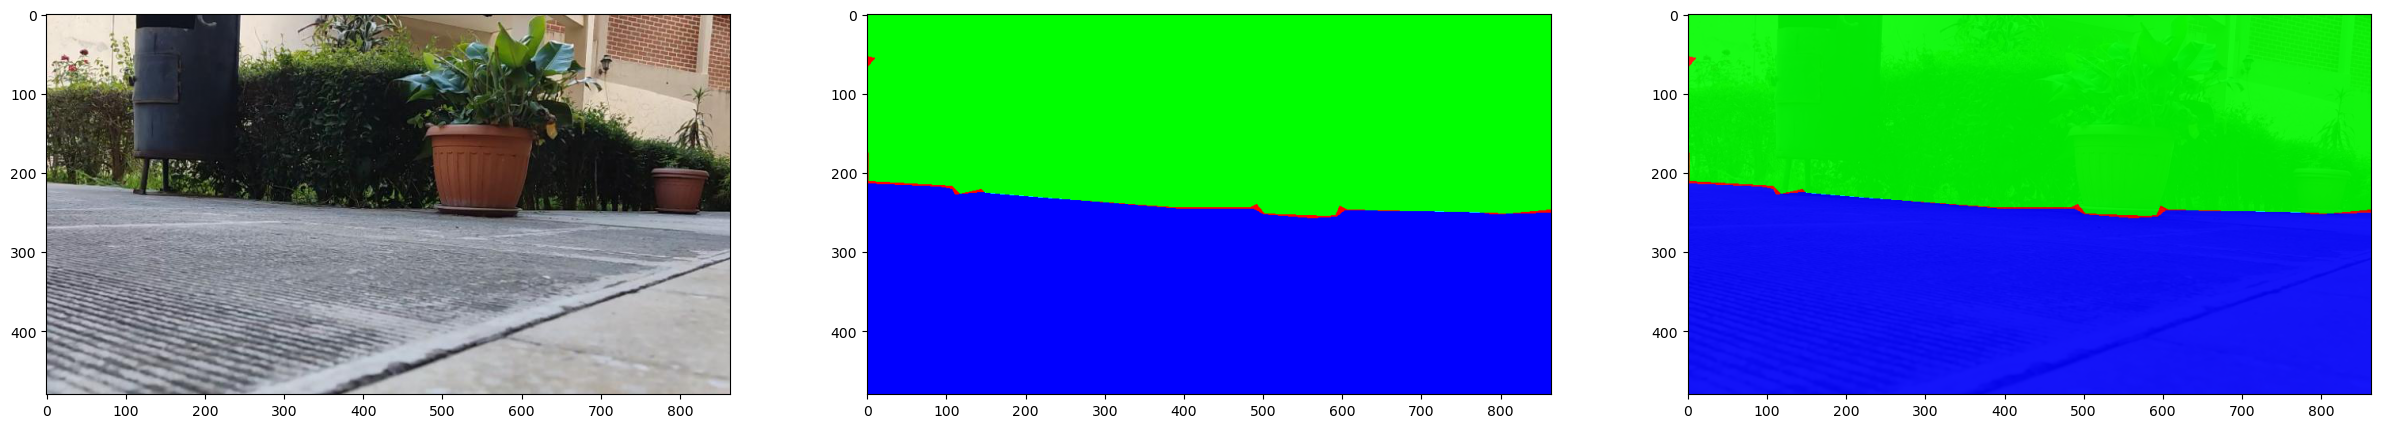

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ix = 99
img = imgs[ix]
mask = masks[ix]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.9)
plt.show()

In [30]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((480, 864, 3), dtype('float64'), 1.0, 0.0)

In [31]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((480, 864, 3), dtype('float64'), 1.0, 0.0)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [2]:
import torch.nn.functional as F
import torch
import torchvision

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Hacemos las pruebas para ver que todo está bien.

In [3]:
model = UNetResnet()
output = model(torch.randn((1,3,480,864)))
output.shape

torch.Size([1, 3, 480, 864])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [35]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 480, 864]), torch.Size([1, 3, 480, 864]))

In [36]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.68551
Epoch 2/50 loss 0.62951
Epoch 3/50 loss 0.56870
Epoch 4/50 loss 0.51839
Epoch 5/50 loss 0.47867
Epoch 6/50 loss 0.44677
Epoch 7/50 loss 0.42272
Epoch 8/50 loss 0.40494
Epoch 9/50 loss 0.39192
Epoch 10/50 loss 0.38200
Epoch 11/50 loss 0.37353
Epoch 12/50 loss 0.36609
Epoch 13/50 loss 0.35973
Epoch 14/50 loss 0.35405
Epoch 15/50 loss 0.34884
Epoch 16/50 loss 0.34388
Epoch 17/50 loss 0.33925
Epoch 18/50 loss 0.33500
Epoch 19/50 loss 0.33105
Epoch 20/50 loss 0.32712
Epoch 21/50 loss 0.32323
Epoch 22/50 loss 0.31969
Epoch 23/50 loss 0.31646
Epoch 24/50 loss 0.31338
Epoch 25/50 loss 0.31044
Epoch 26/50 loss 0.30759
Epoch 27/50 loss 0.30478
Epoch 28/50 loss 0.30193
Epoch 29/50 loss 0.29912
Epoch 30/50 loss 0.29646
Epoch 31/50 loss 0.29393
Epoch 32/50 loss 0.29147
Epoch 33/50 loss 0.28908
Epoch 34/50 loss 0.28682
Epoch 35/50 loss 0.28452
Epoch 36/50 loss 0.28215
Epoch 37/50 loss 0.27980
Epoch 38/50 loss 0.27754
Epoch 39/50 loss 0.27532
Epoch 40/50 loss 0.27315
Epoch 41/

Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

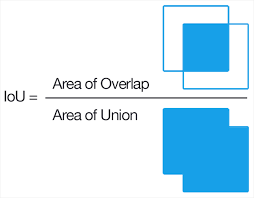

In [4]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [38]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.25127 iou 0.49708
Epoch 2/100 loss 0.57590 iou 0.14916
Epoch 3/100 loss 0.40276 iou 0.34128
Epoch 4/100 loss 0.27900 iou 0.48025
Epoch 5/100 loss 0.24667 iou 0.49416
Epoch 6/100 loss 0.23991 iou 0.49096
Epoch 7/100 loss 0.23395 iou 0.48979
Epoch 8/100 loss 0.22704 iou 0.49047
Epoch 9/100 loss 0.21970 iou 0.49244
Epoch 10/100 loss 0.21206 iou 0.49414
Epoch 11/100 loss 0.20487 iou 0.49528
Epoch 12/100 loss 0.19836 iou 0.49626
Epoch 13/100 loss 0.19243 iou 0.49669
Epoch 14/100 loss 0.18679 iou 0.49696
Epoch 15/100 loss 0.18101 iou 0.49701
Epoch 16/100 loss 0.17549 iou 0.49708
Epoch 17/100 loss 0.17026 iou 0.49709
Epoch 18/100 loss 0.16527 iou 0.49710
Epoch 19/100 loss 0.16049 iou 0.49711
Epoch 20/100 loss 0.15588 iou 0.49712
Epoch 21/100 loss 0.15144 iou 0.49703
Epoch 22/100 loss 0.14716 iou 0.49692
Epoch 23/100 loss 0.14301 iou 0.49685
Epoch 24/100 loss 0.13897 iou 0.49681
Epoch 25/100 loss 0.13501 iou 0.49689
Epoch 26/100 loss 0.13118 iou 0.49702
Epoch 27/100 loss 0.1

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

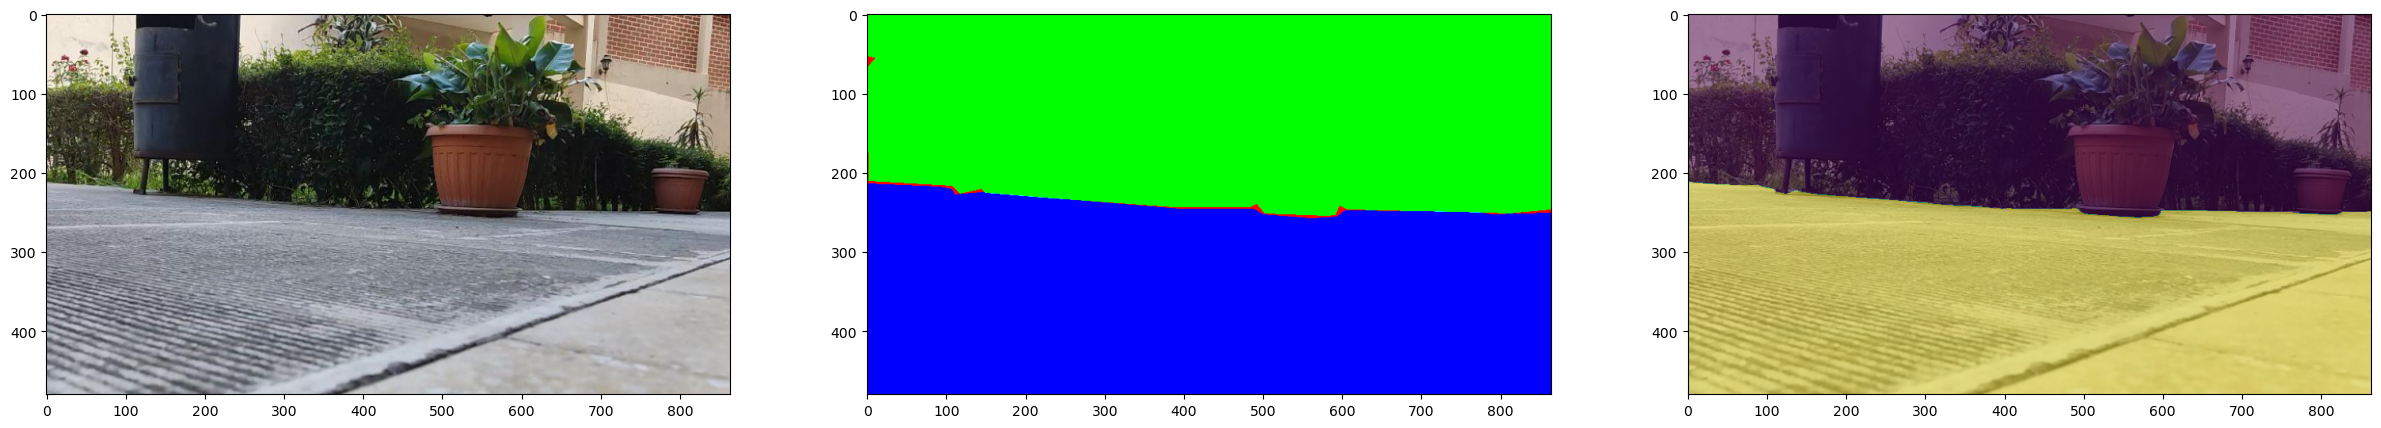

In [39]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0) #type: ignore
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.5)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [6]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(5292, 502)

In [7]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 480, 864]), torch.Size([3, 480, 864]))

In [8]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=6, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([6, 3, 480, 864]), torch.Size([6, 3, 480, 864]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [9]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"./models/UNetResNet_model_seg_v2_{epoch}.pt")
        
    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente. 

In [10]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.08559 test_iou 0.59653: 100%|██████████| 32/32 [01:31<00:00,  2.87s/it]



Epoch 1/10 loss 0.14161 iou 0.56223 test_loss 0.08559 test_iou 0.59653


test_loss 0.06129 test_iou 0.60966: 100%|██████████| 32/32 [02:04<00:00,  3.89s/it]



Epoch 2/10 loss 0.06934 iou 0.61346 test_loss 0.06129 test_iou 0.60966


test_loss 0.06097 test_iou 0.60192: 100%|██████████| 32/32 [02:31<00:00,  4.74s/it]



Epoch 3/10 loss 0.05710 iou 0.61793 test_loss 0.06097 test_iou 0.60192


test_loss 0.05839 test_iou 0.60375: 100%|██████████| 32/32 [02:33<00:00,  4.79s/it]



Epoch 4/10 loss 0.05148 iou 0.62516 test_loss 0.05839 test_iou 0.60375


test_loss 0.04959 test_iou 0.63076: 100%|██████████| 32/32 [01:23<00:00,  2.62s/it]



Epoch 5/10 loss 0.04466 iou 0.62891 test_loss 0.04959 test_iou 0.63076


loss 0.02816 iou 0.63688:   3%|▎         | 25/882 [00:20<11:49,  1.21it/s]


KeyboardInterrupt: 

Vemos que la precisión de nuestro modelo es bastante bueno, la mejor llega al `94.43%` y con un error del `1.25%`, esto nos indica que el modelo está funcionando correctamente.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

NameError: name 'hist' is not defined

In [12]:
import matplotlib.colors as mcolors

classes = ['camino', 'obstaculo', 'background']
colors = ['#1f77b4', '#ff9e80', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

175


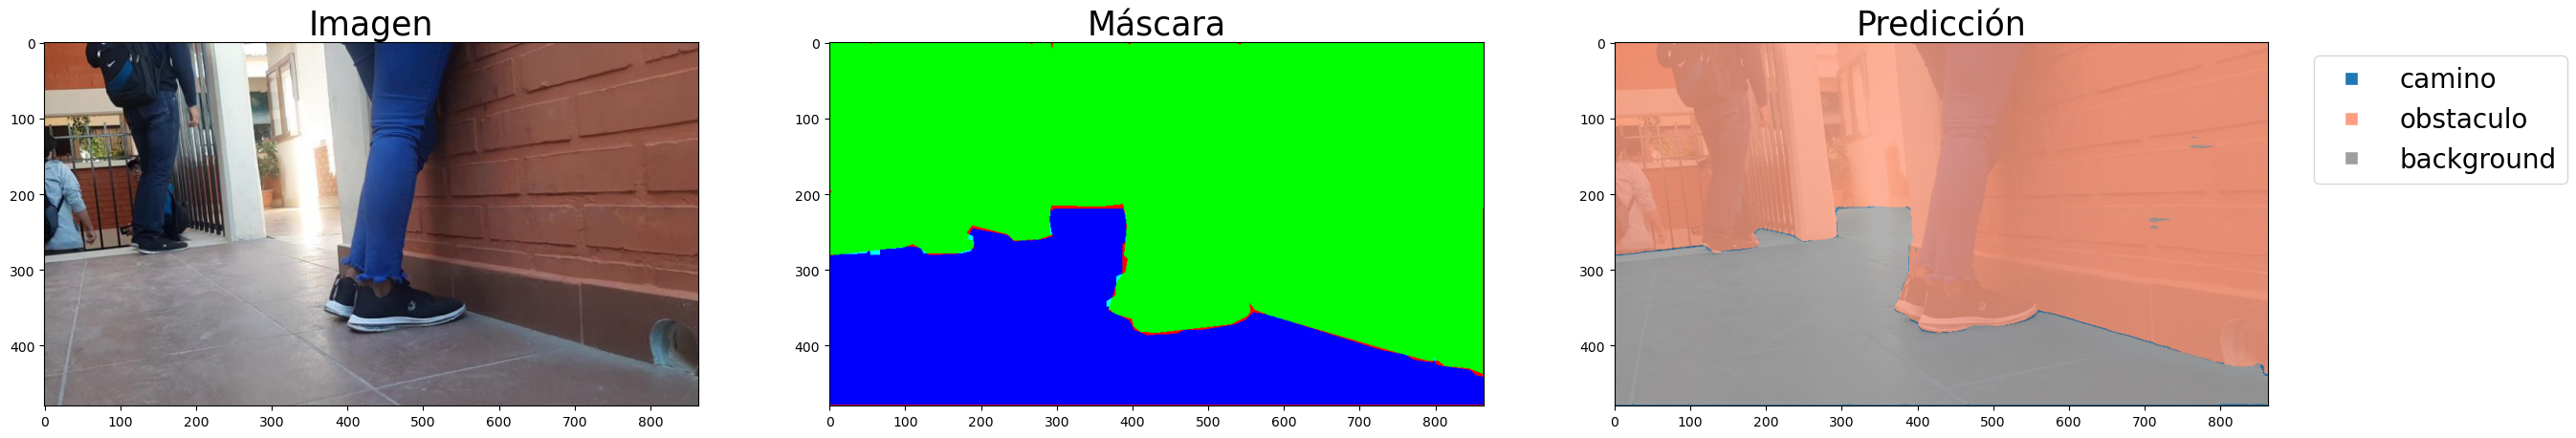

In [17]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#ix = 99
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

369


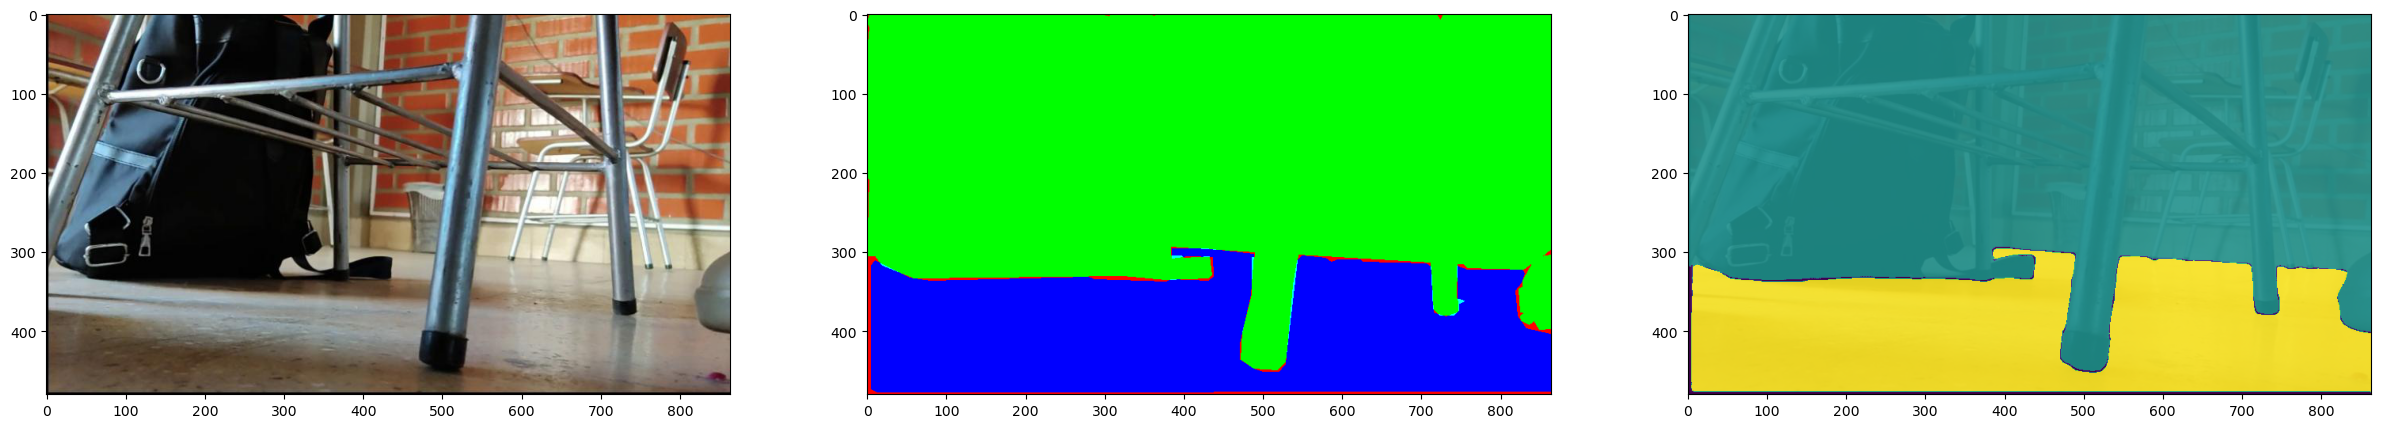

In [68]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
print(ix)
img, mask = dataset['test'][ix]
img_tensor = img.clone().detach().unsqueeze(0).to(device).float()
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0) #type: ignore
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
ax2.imshow(mask.squeeze().permute(1, 2, 0).cpu().numpy())
ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.9)
plt.show()

## Resultados

Precisión de Yolov8: 